# DonorsChoose

<p>
DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website.
</p>
<p>
    Next year, DonorsChoose.org expects to receive close to 500,000 project proposals. As a result, there are three main problems they need to solve:
<ul>
<li>
    How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible</li>
    <li>How to increase the consistency of project vetting across different volunteers to improve the experience for teachers</li>
    <li>How to focus volunteer time on the applications that need the most assistance</li>
    </ul>
</p>    
<p>
The goal of the competition is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.
</p>

## About the DonorsChoose Data Set

The `train.csv` data set provided by DonorsChoose contains the following features:

Feature | Description 
----------|---------------
**`project_id`** | A unique identifier for the proposed project. **Example:** `p036502`   
**`project_title`**    | Title of the project. **Examples:**<br><ul><li><code>Art Will Make You Happy!</code></li><li><code>First Grade Fun</code></li></ul> 
**`project_grade_category`** | Grade level of students for which the project is targeted. One of the following enumerated values: <br/><ul><li><code>Grades PreK-2</code></li><li><code>Grades 3-5</code></li><li><code>Grades 6-8</code></li><li><code>Grades 9-12</code></li></ul>  
 **`project_subject_categories`** | One or more (comma-separated) subject categories for the project from the following enumerated list of values:  <br/><ul><li><code>Applied Learning</code></li><li><code>Care &amp; Hunger</code></li><li><code>Health &amp; Sports</code></li><li><code>History &amp; Civics</code></li><li><code>Literacy &amp; Language</code></li><li><code>Math &amp; Science</code></li><li><code>Music &amp; The Arts</code></li><li><code>Special Needs</code></li><li><code>Warmth</code></li></ul><br/> **Examples:** <br/><ul><li><code>Music &amp; The Arts</code></li><li><code>Literacy &amp; Language, Math &amp; Science</code></li>  
  **`school_state`** | State where school is located ([Two-letter U.S. postal code](https://en.wikipedia.org/wiki/List_of_U.S._state_abbreviations#Postal_codes)). **Example:** `WY`
**`project_subject_subcategories`** | One or more (comma-separated) subject subcategories for the project. **Examples:** <br/><ul><li><code>Literacy</code></li><li><code>Literature &amp; Writing, Social Sciences</code></li></ul> 
**`project_resource_summary`** | An explanation of the resources needed for the project. **Example:** <br/><ul><li><code>My students need hands on literacy materials to manage sensory needs!</code</li></ul> 
**`project_essay_1`**    | First application essay<sup>*</sup>  
**`project_essay_2`**    | Second application essay<sup>*</sup> 
**`project_essay_3`**    | Third application essay<sup>*</sup> 
**`project_essay_4`**    | Fourth application essay<sup>*</sup> 
**`project_submitted_datetime`** | Datetime when project application was submitted. **Example:** `2016-04-28 12:43:56.245`   
**`teacher_id`** | A unique identifier for the teacher of the proposed project. **Example:** `bdf8baa8fedef6bfeec7ae4ff1c15c56`  
**`teacher_prefix`** | Teacher's title. One of the following enumerated values: <br/><ul><li><code>nan</code></li><li><code>Dr.</code></li><li><code>Mr.</code></li><li><code>Mrs.</code></li><li><code>Ms.</code></li><li><code>Teacher.</code></li></ul>  
**`teacher_number_of_previously_posted_projects`** | Number of project applications previously submitted by the same teacher. **Example:** `2` 

<sup>*</sup> See the section <b>Notes on the Essay Data</b> for more details about these features.

Additionally, the `resources.csv` data set provides more data about the resources required for each project. Each line in this file represents a resource required by a project:

Feature | Description 
----------|---------------
**`id`** | A `project_id` value from the `train.csv` file.  **Example:** `p036502`   
**`description`** | Desciption of the resource. **Example:** `Tenor Saxophone Reeds, Box of 25`   
**`quantity`** | Quantity of the resource required. **Example:** `3`   
**`price`** | Price of the resource required. **Example:** `9.95`   

**Note:** Many projects require multiple resources. The `id` value corresponds to a `project_id` in train.csv, so you use it as a key to retrieve all resources needed for a project:

The data set contains the following label (the value you will attempt to predict):

Label | Description
----------|---------------
`project_is_approved` | A binary flag indicating whether DonorsChoose approved the project. A value of `0` indicates the project was not approved, and a value of `1` indicates the project was approved.

### Notes on the Essay Data

<ul>
Prior to May 17, 2016, the prompts for the essays were as follows:
<li>__project_essay_1:__ "Introduce us to your classroom"</li>
<li>__project_essay_2:__ "Tell us more about your students"</li>
<li>__project_essay_3:__ "Describe how your students will use the materials you're requesting"</li>
<li>__project_essay_3:__ "Close by sharing why your project will make a difference"</li>
</ul>


<ul>
Starting on May 17, 2016, the number of essays was reduced from 4 to 2, and the prompts for the first 2 essays were changed to the following:<br>
<li>__project_essay_1:__ "Describe your students: What makes your students special? Specific details about their background, your neighborhood, and your school are all helpful."</li>
<li>__project_essay_2:__ "About your project: How will these materials make a difference in your students' learning and improve their school lives?"</li>
<br>For all projects with project_submitted_datetime of 2016-05-17 and later, the values of project_essay_3 and project_essay_4 will be NaN.
</ul>


In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import dill
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter
from wordcloud import WordCloud

D:\Softwares\Anaconda\envs\AAIC\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## 1.1 Reading Data

In [2]:
project_data = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')

**Taking only 50K points as Training runs slower with many points**

In [3]:
import random
project_data = project_data.loc[random.sample(list(project_data.index), 50000)]

In [4]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (50000, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [5]:
print("Number of data points in train data", resource_data.shape)
print(resource_data.columns.values)
resource_data.head(2)

Number of data points in train data (1541272, 4)
['id' 'description' 'quantity' 'price']


id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   

    price  
0  149.00  
1   14.95

## 1.2 preprocessing of `project_subject_categories`

In [6]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())
    
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))


## 1.3 preprocessing of `project_subject_subcategories`

In [7]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

## 1.3 Text preprocessing

In [8]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [9]:
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
69722       79480  p045266  a3cd759de4924a1a7dbfb16cd59f444d           Mrs.   
38481      135951  p060970  7125cd2ad94bbdbc44c3c98eab53808b           Mrs.   

      school_state project_submitted_datetime project_grade_category  \
69722           UT        2016-09-01 08:15:55             Grades 3-5   
38481           IN        2016-07-06 22:17:29             Grades 3-5   

                                           project_title  \
69722  Student Scientists Creating Simple Machines fo...   
38481                        Learning Beyond the Screen!   

                                         project_essay_1  \
69722  As a teacher in a low-income/high poverty scho...   
38481  As a teacher in a Title I school my students a...   

                                         project_essay_2 project_essay_3  \
69722  How can simple machines change the lives of th...             NaN   
38481  My students need more experience with technolo...             NaN   

      project_essay_4                           project_resource_summary  \
69722             NaN  My students need materials such as: twine, cla...   
38481             NaN  My students need the Osmo Wonder kit to help t...   

       teacher_number_of_previously_posted_projects  project_is_approved  \
69722                                            10                    0   
38481                                             0                    1   

                     clean_categories                 clean_subcategories  \
69722                    Math_Science  AppliedSciences Health_LifeScience   
38481  Literacy_Language Math_Science                     ESL Mathematics   

                                                   essay  
69722  As a teacher in a low-income/high poverty scho...  
38481  As a teacher in a Title I school my students a...

In [10]:
#### 1.4.2.3 Using Pretrained Models: TFIDF weighted W2V

In [11]:
# printing some random reviews
print(project_data['essay'].values[0])
print("="*50)
print(project_data['essay'].values[150])
print("="*50)
print(project_data['essay'].values[1000])
print("="*50)
print(project_data['essay'].values[20000])
print("="*50)

As a teacher in a low-income/high poverty school district, many students are faced with several challenges both in and out of the classroom. Despite the challenges they face, students come into the classroom eager to learn. I am looking to provide my students with creative and meaningful learning experiences through the power of choice, self determination, inquiry, and teamwork.\r\n\r\nMy students are hardworking, positive, and eager learners. They like to move; they love to read, explore, and love lots of positive attention. Many student families face hardships. Most families receive a free lunch based on their socioeconomic status. These things may prevent them from getting ahead, but no matter their challenges, students are eager to learn.\r\n\r\nFrom the minute students walk in the door of our classroom, I focus on their potential and growth while they are with me. By doing this in a creative and positive way, I am hopeful to inspire students to understand themselves as learners st

In [12]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [13]:
sent = decontracted(project_data['essay'].values[20000])
print(sent)
print("="*50)

Our high school is located in a 100 + year old elementary school, but the students never let this deter them. They come to class every day prepared to work hard for what they want. These students are some of the most hard-working, determined people I have ever had the pleasure of knowing.\r\nMy student are used to working to overcome adversity in their lives; I would love to help make one aspect of their lives less of a struggle. I would like to help them do so by providing them with the resources they need.  We may have not all of the resources that we would like, but we work with what we have. In today is world it is so important that my students learn how to use technology they do not have at home, and that is what I want to help with.\t\r\nCurrently when we have a presentation, project, or paper assigned, the students have to take turns trying to do this on the eight chromebooks we have). We also try to borrow a few spare Chromebooks from other teachers if they are free for the day

In [14]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent)

Our high school is located in a 100 + year old elementary school, but the students never let this deter them. They come to class every day prepared to work hard for what they want. These students are some of the most hard-working, determined people I have ever had the pleasure of knowing.  My student are used to working to overcome adversity in their lives; I would love to help make one aspect of their lives less of a struggle. I would like to help them do so by providing them with the resources they need.  We may have not all of the resources that we would like, but we work with what we have. In today is world it is so important that my students learn how to use technology they do not have at home, and that is what I want to help with.\t  Currently when we have a presentation, project, or paper assigned, the students have to take turns trying to do this on the eight chromebooks we have). We also try to borrow a few spare Chromebooks from other teachers if they are free for the day. My

In [15]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

Our high school is located in a 100 year old elementary school but the students never let this deter them They come to class every day prepared to work hard for what they want These students are some of the most hard working determined people I have ever had the pleasure of knowing My student are used to working to overcome adversity in their lives I would love to help make one aspect of their lives less of a struggle I would like to help them do so by providing them with the resources they need We may have not all of the resources that we would like but we work with what we have In today is world it is so important that my students learn how to use technology they do not have at home and that is what I want to help with t Currently when we have a presentation project or paper assigned the students have to take turns trying to do this on the eight chromebooks we have We also try to borrow a few spare Chromebooks from other teachers if they are free for the day My students need new Chro

In [16]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't", "nannan", "nan"]

In [17]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_essays.append(sent.lower().strip())

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [00:57<00:00, 873.56it/s]


In [18]:
# after preprocesing
preprocessed_essays[20000]

'our high school located 100 year old elementary school students never let deter they come class every day prepared work hard want these students hard working determined people i ever pleasure knowing my student used working overcome adversity lives i would love help make one aspect lives less struggle i would like help providing resources need we may not resources would like work in today world important students learn use technology not home i want help currently presentation project paper assigned students take turns trying eight chromebooks we also try borrow spare chromebooks teachers free day my students need new chromebooks classroom they thrilled opportunity research projects papers new computers rather trying share 8 chromebooks currently that amount not even cover third students class rest students must use personal phones research write huge hassle the students able research information learn technologically literate time providing computers students access wealth knowledge 

<h2><font color='red'> 1.4 Preprocessing of `project_title`</font></h2>

### Following Code blocks provided by me.

In [19]:
# Code took from original code provided.
# Also function used from original code.
preprocessed_titles = []

for sent in tqdm(project_data['project_title'].values):
    sent = decontracted(sent)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    sent = ' '.join(e.lower() for e in sent.split() if e.lower() not in stopwords)
    preprocessed_titles.append(sent.lower().strip())

100%|█████████████████████████████████████████████████████████████████████████| 50000/50000 [00:02<00:00, 20788.14it/s]


In [20]:
preprocessed_titles[20000]

'research ready chromebooks'

### Following Code blocks present in original notebook.

## 1.5 Preparing data for models

In [21]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_essay_2', 'project_essay_3',
       'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay'],
      dtype='object')

we are going to consider

       - school_state : categorical data
       - clean_categories : categorical data
       - clean_subcategories : categorical data
       - project_grade_category : categorical data
       - teacher_prefix : categorical data
       
       - project_title : text data
       - text : text data
       - project_resource_summary: text data (optinal)
       
       - quantity : numerical (optinal)
       - teacher_number_of_previously_posted_projects : numerical
       - price : numerical

### 1.5.1 Vectorizing Categorical data

- https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/

In [22]:
# we use count vectorizer to convert the values into one 
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(vocabulary=list(sorted_cat_dict.keys()), lowercase=False, binary=True)
categories_one_hot = vectorizer.fit_transform(project_data['clean_categories'].values)
print(vectorizer.get_feature_names())
print("Shape of matrix after one hot encodig ",categories_one_hot.shape)

['Warmth', 'Care_Hunger', 'History_Civics', 'Music_Arts', 'AppliedLearning', 'SpecialNeeds', 'Health_Sports', 'Math_Science', 'Literacy_Language']
Shape of matrix after one hot encodig  (50000, 9)


In [23]:
# we use count vectorizer to convert the values into one 
vectorizer = CountVectorizer(vocabulary=list(sorted_sub_cat_dict.keys()), lowercase=False, binary=True)
sub_categories_one_hot = vectorizer.fit_transform(project_data['clean_subcategories'].values)
print(vectorizer.get_feature_names())
print("Shape of matrix after one hot encodig ",sub_categories_one_hot.shape)

['Economics', 'CommunityService', 'FinancialLiteracy', 'ParentInvolvement', 'Extracurricular', 'Civics_Government', 'ForeignLanguages', 'Warmth', 'Care_Hunger', 'NutritionEducation', 'SocialSciences', 'PerformingArts', 'CharacterEducation', 'TeamSports', 'Other', 'College_CareerPrep', 'History_Geography', 'Music', 'Health_LifeScience', 'EarlyDevelopment', 'ESL', 'Gym_Fitness', 'EnvironmentalScience', 'VisualArts', 'Health_Wellness', 'AppliedSciences', 'SpecialNeeds', 'Literature_Writing', 'Mathematics', 'Literacy']
Shape of matrix after one hot encodig  (50000, 30)


In [24]:
# you can do the similar thing with state, teacher_prefix and project_grade_category also

### Following Code blocks provided by me.

In [25]:
# Code took from original code provided.
states = project_data['school_state'].unique()
vectorizer = CountVectorizer(vocabulary=list(states), lowercase=False, binary=True)
vectorizer.fit(project_data['school_state'].values)
print(vectorizer.get_feature_names())

school_state_one_hot = vectorizer.transform(project_data['school_state'].values)
print("Shape of matrix after one hot encoding", school_state_one_hot.shape)

['UT', 'IN', 'SC', 'IL', 'MA', 'NV', 'CA', 'KY', 'NY', 'MO', 'WI', 'ME', 'CO', 'LA', 'MI', 'GA', 'FL', 'TX', 'NC', 'MN', 'CT', 'VA', 'OR', 'AZ', 'DC', 'WV', 'OH', 'OK', 'AR', 'VT', 'SD', 'NJ', 'IA', 'MS', 'WA', 'PA', 'MD', 'TN', 'AK', 'NH', 'AL', 'NE', 'RI', 'ND', 'NM', 'ID', 'KS', 'MT', 'HI', 'DE', 'WY']
Shape of matrix after one hot encoding (50000, 51)


There are some NaN's in teacher_prefix column. replacing them with 'Mrs.' as that has high occurance in that column.

In [26]:
print("Number of NaN's before replacement in column: ", sum(project_data['teacher_prefix'].isna()))
project_data['teacher_prefix'] = project_data['teacher_prefix'].replace(np.nan, 'Mrs.', regex=True)
print("Number of NaN's after replacement in column: ", sum(project_data['teacher_prefix'].isna()))

# Output may show both zeros as I re-run this several times. But there are 3 zeros in original column.

Number of NaN's before replacement in column:  1
Number of NaN's after replacement in column:  0


In [27]:
# Code took from original code provided.
prefixes = project_data['teacher_prefix'].unique()
vectorizer = CountVectorizer(vocabulary=list(prefixes), lowercase=False, binary=True)
vectorizer.fit(project_data['teacher_prefix'].values)
print(vectorizer.get_feature_names())

teacher_prefix_one_hot = vectorizer.transform(project_data['teacher_prefix'].values)
print("Shape of matrix after one hot encoding", teacher_prefix_one_hot.shape)

['Mrs.', 'Mr.', 'Ms.', 'Teacher', 'Dr.']
Shape of matrix after one hot encoding (50000, 5)


In [28]:
grades = project_data['project_grade_category'].unique()
vectorizer = CountVectorizer(vocabulary=list(grades), lowercase=False, binary=True)
vectorizer.fit(project_data['project_grade_category'].values)
print(vectorizer.get_feature_names())

project_grade_category_one_hot = vectorizer.transform(project_data['project_grade_category'].values)
print("Shape of matrix after one hot encoding", project_grade_category_one_hot.shape)

['Grades 3-5', 'Grades 6-8', 'Grades PreK-2', 'Grades 9-12']
Shape of matrix after one hot encoding (50000, 4)


### Following Code blocks present in original notebook.

### 1.5.2 Vectorizing Text data

#### 1.5.2.1 Bag of words

In [29]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer = CountVectorizer(min_df=10)
text_bow = vectorizer.fit_transform(preprocessed_essays)
print("Shape of matrix after one hot encodig ",text_bow.shape)

Shape of matrix after one hot encodig  (50000, 12258)


In [30]:
# you can vectorize the title also 
# before you vectorize the title make sure you preprocess it

### Following Code blocks provided by me.

In [31]:
# Code took from original code provided.
# We are considering only the words which appeared in at least 5 documents(rows or projects).
# Reduced number as title has less words
vectorizer = CountVectorizer(min_df=10)
titles_bow = vectorizer.fit_transform(preprocessed_titles)
print("Shape of matrix after one hot encodig ", titles_bow.shape)

Shape of matrix after one hot encodig  (50000, 2025)


### Following Code blocks present in original notebook.

#### 1.5.2.2 TFIDF vectorizer

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)
text_tfidf = vectorizer.fit_transform(preprocessed_essays)
print("Shape of matrix after one hot encodig ",text_tfidf.shape)

Shape of matrix after one hot encodig  (50000, 12258)


#### 1.5.2.3 Using Pretrained Models: Avg W2V

In [33]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [34]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors.append(vector)

print(len(avg_w2v_vectors))
print(len(avg_w2v_vectors[0]))

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:29<00:00, 1686.30it/s]


50000
300


#### 1.5.2.3 Using Pretrained Models: TFIDF weighted W2V

In [35]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_essays)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [36]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors.append(vector)

print(len(tfidf_w2v_vectors))
print(len(tfidf_w2v_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [03:31<00:00, 236.62it/s]


50000
300


In [37]:
# Similarly you can vectorize for title also

### Following Code blocks provided by me.

In [38]:
# Code took from original code provided.
# tfidf of project titles
vectorizer = TfidfVectorizer(min_df=10)
titles_tfidf = vectorizer.fit_transform(preprocessed_titles)
print("Shape of matrix after one hot encodig ",titles_tfidf.shape)

Shape of matrix after one hot encodig  (50000, 2025)


In [39]:
# Code took from original code provided.
# avg-w2v for project titles
avg_w2v_titles = []
for sentence in tqdm(preprocessed_titles):
    vector = np.zeros(300)
    cnt_words =0;
    for word in sentence.split():
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_titles.append(vector)

print(len(avg_w2v_titles))
print(len(avg_w2v_titles[0]))

100%|█████████████████████████████████████████████████████████████████████████| 50000/50000 [00:01<00:00, 38493.33it/s]


50000
300


In [40]:
# Code took from original code provided.
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_titles)
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [41]:
# Code took from original code provided.
# tfidf-w2v for project titles
tfidf_w2v_titles = []
for sentence in tqdm(preprocessed_titles):
    vector = np.zeros(300)
    tf_idf_weight =0
    for word in sentence.split():
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word]
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split()))
            vector += (vec * tf_idf)
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_titles.append(vector)

print(len(tfidf_w2v_titles))
print(len(tfidf_w2v_titles[0]))

100%|█████████████████████████████████████████████████████████████████████████| 50000/50000 [00:02<00:00, 19655.51it/s]


50000
300


### Following Code blocks present in original notebook.

### 1.5.3 Vectorizing Numerical features

In [42]:
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [43]:
# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# standardization sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler

# price_standardized = standardScalar.fit(project_data['price'].values)
# this will rise the error
# ValueError: Expected 2D array, got 1D array instead: array=[725.05 213.03 329.   ... 399.   287.73   5.5 ].
# Reshape your data either using array.reshape(-1, 1)

price_scalar = StandardScaler()
price_scalar.fit(project_data['price'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
price_standardized = price_scalar.transform(project_data['price'].values.reshape(-1, 1))

Mean : 297.4139702, Standard deviation : 365.5914197335812


In [44]:
price_standardized

array([[ 1.12813378],
       [-0.40327525],
       [ 0.20141619],
       ...,
       [-0.48530671],
       [-0.2883929 ],
       [-0.4786873 ]])

### Following Code blocks provided by me.

In [45]:
warnings.filterwarnings("ignore")
# Code took from original code provided
scalar = StandardScaler()
scalar.fit(project_data['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
print(f"Mean : {scalar.mean_[0]}, Standard deviation : {np.sqrt(scalar.var_[0])}")

# Now standardize the data with above maen and variance.
previously_posted_projects_standardized = \
                scalar.transform(project_data['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
print(previously_posted_projects_standardized)

Mean : 11.24058, Standard deviation : 27.947352312224496
[[-0.04438989]
 [-0.40220554]
 [-0.36642398]
 ...
 [-0.18751615]
 [-0.36642398]
 [-0.36642398]]


### Following Code blocks present in original notebook.

### 1.5.4 Merging all the above features

- we need to merge all the numerical vectors i.e catogorical, text, numerical vectors

In [46]:
print(categories_one_hot.shape)
print(sub_categories_one_hot.shape)
print(text_bow.shape)
print(price_standardized.shape)

(50000, 9)
(50000, 30)
(50000, 12258)
(50000, 1)


In [47]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X = hstack((categories_one_hot, sub_categories_one_hot, text_bow, price_standardized))
X.shape

(50000, 12298)

In [48]:
# please write all the code with proper documentation, and proper titles for each subsection
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

__ Computing Sentiment Scores__

In [49]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# import nltk
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

for_sentiment = 'a person is a person no matter how small dr seuss i teach the smallest students with the biggest enthusiasm \
for learning my students learn in many different ways using all of our senses and multiple intelligences i use a wide range\
of techniques to help all my students succeed students in my class come from a variety of different backgrounds which makes\
for wonderful sharing of experiences and cultures including native americans our school is a caring community of successful \
learners which can be seen through collaborative student project based learning in and out of the classroom kindergarteners \
in my class love to work with hands on materials and have many different opportunities to practice a skill before it is\
mastered having the social skills to work cooperatively with friends is a crucial aspect of the kindergarten curriculum\
montana is the perfect place to learn about agriculture and nutrition my students love to role play in our pretend kitchen\
in the early childhood classroom i have had several kids ask me can we try cooking with real food i will take their idea \
and create common core cooking lessons where we learn important math and writing concepts while cooking delicious healthy \
food for snack time my students will have a grounded appreciation for the work that went into making the food and knowledge \
of where the ingredients came from as well as how it is healthy for their bodies this project would expand our learning of \
nutrition and agricultural cooking recipes by having us peel our own apples to make homemade applesauce make our own bread \
and mix up healthy plants from our classroom garden in the spring we will also create our own cookbooks to be printed and \
shared with families students will gain math and literature skills as well as a life long enjoyment for healthy cooking \
nannan'
ss = sid.polarity_scores(for_sentiment)

for k in ss:
    print('{0}: {1}, '.format(k, ss[k]), end='')

# we can use these 4 things as features/attributes (neg, neu, pos, compound)
# neg: 0.0, neu: 0.753, pos: 0.247, compound: 0.93

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\724463\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


neg: 0.01, neu: 0.745, pos: 0.245, compound: 0.9975, 

# Assignment 8: DT

<ol>
    <li><strong>Apply Decision Tree Classifier(DecisionTreeClassifier) on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical, numerical features + project_title(BOW) + preprocessed_eassay (BOW)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features + project_title(TFIDF)+  preprocessed_eassay (TFIDF)</li>
            <li><font color='red'>Set 3</font>: categorical, numerical features + project_title(AVG W2V)+  preprocessed_eassay (AVG W2V)</li>
            <li><font color='red'>Set 4</font>: categorical, numerical features + project_title(TFIDF W2V)+  preprocessed_eassay (TFIDF W2V)</li>        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (best `depth` in range [1, 5, 10, 50, 100, 500, 100], and the best `min_samples_split` in range [5, 10, 100, 500])</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li> 
        </ul>
    </li>
    <br>
    <li><strong>Graphviz</strong>
        <ul>
    <li>Visualize your decision tree with Graphviz. It helps you to understand how a decision is being made, given a new vector.</li>
    <li>Since feature names are not obtained from word2vec related models, visualize only BOW & TFIDF decision trees using Graphviz</li>
    <li>Make sure to print the words in each node of the decision tree instead of printing its index.</li>
    <li>Just for visualization purpose, limit max_depth to 2 or 3 and either embed the generated images of graphviz in your notebook, or directly upload them as .png files.</li>                
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
    <li>Once after you plot the confusion matrix with the test data, get all the `false positive data points`
        <ul>
            <li> Plot the WordCloud <a href='https://www.geeksforgeeks.org/generating-word-cloud-python/' with the words of eassy text of these `false positive data points`>WordCloud</a></li>
            <li> Plot the box plot with the `price` of these `false positive data points`</li>
            <li> Plot the pdf with the `teacher_number_of_previously_posted_projects` of these `false positive data points`</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>[Task-2]</strong>
        <ul>
    <li> Select 5k best features from features of <font color='red'>Set 2</font> using<a href='https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html'>`feature_importances_`</a>, discard all the other remaining features and then apply any of the model of you choice i.e. (Dession tree, Logistic Regression, Linear SVM), you need to do hyperparameter tuning corresponding to the model you selected and procedure in step 2 and step 3</li>
        </ul>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h1>2. Decision Tree </h1>

### Some code blocks are taken from previous assignments. And some used the code present in original file ('8_DonorsChoose_DT.ipynb') which is mentioned in comments.

### Following Code blocks provided by me.

**Adding a column `summary_numeric_bool` instead of `project_resource_summary` column which tells if resource summary has a number in it**

In [50]:
# ref: https://stackoverflow.com/questions/4138202/using-isdigit-for-floats
def nums_in_str(text):
    """
    Returns list of numbers present in the given string. Numbers := floats ints etc.
    """
    result = []
    for s in text.split():
        try:
            x = float(s)
            result.append(x)
        except:
            continue
    return result

In [51]:
print(nums_in_str('HE44LLo 56 are -89 I 820.353 in -78.39 what .293 about 00'))

[56.0, -89.0, 820.353, -78.39, 0.293, 0.0]


In [52]:
numbers_in_summary = np.array([len(nums_in_str(s)) for s in project_data['project_resource_summary']])
project_data['summary_numeric_bool'] = list(map(int, numbers_in_summary>0))

### Taking Relevant columns as X (input data to model) and y (output class label)

In [53]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_essay_2', 'project_essay_3',
       'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price', 'quantity',
       'summary_numeric_bool'],
      dtype='object')

In [54]:
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0       79480  p045266  a3cd759de4924a1a7dbfb16cd59f444d           Mrs.   
1      135951  p060970  7125cd2ad94bbdbc44c3c98eab53808b           Mrs.   

  school_state project_submitted_datetime project_grade_category  \
0           UT        2016-09-01 08:15:55             Grades 3-5   
1           IN        2016-07-06 22:17:29             Grades 3-5   

                                       project_title  \
0  Student Scientists Creating Simple Machines fo...   
1                        Learning Beyond the Screen!   

                                     project_essay_1  \
0  As a teacher in a low-income/high poverty scho...   
1  As a teacher in a Title I school my students a...   

                                     project_essay_2          ...           \
0  How can simple machines change the lives of th...          ...            
1  My students need more experience with technolo...          ...            

  project_essay_4                           project_resource_summary  \
0             NaN  My students need materials such as: twine, cla...   
1             NaN  My students need the Osmo Wonder kit to help t...   

  teacher_number_of_previously_posted_projects  project_is_approved  \
0                                           10                    0   
1                                            0                    1   

                 clean_categories                 clean_subcategories  \
0                    Math_Science  AppliedSciences Health_LifeScience   
1  Literacy_Language Math_Science                     ESL Mathematics   

                                               essay   price  quantity  \
0  As a teacher in a low-income/high poverty scho...  709.85        34   
1  As a teacher in a Title I school my students a...  149.98         1   

   summary_numeric_bool  
0                     0  
1                     0  

[2 rows x 21 columns]

In [55]:
# Categorical and numerical columns are listed below.
X_columns = ['teacher_prefix', 'school_state', 'project_grade_category', 'summary_numeric_bool',\
             'teacher_number_of_previously_posted_projects', 'clean_categories', 'clean_subcategories',\
             'price', 'quantity']
X = project_data[X_columns]
y = project_data['project_is_approved']

**Adding preprocessed_essays and preprocessed_titles as columns to X before splitting**

In [56]:
X['essay'] = preprocessed_essays
X['project_title'] = preprocessed_titles
X_columns.append('essay')
X_columns.append('project_title')
print('final columns used in input data are: ', X_columns)

final columns used in input data are:  ['teacher_prefix', 'school_state', 'project_grade_category', 'summary_numeric_bool', 'teacher_number_of_previously_posted_projects', 'clean_categories', 'clean_subcategories', 'price', 'quantity', 'essay', 'project_title']


**Adding essays and calculating sentiments to Input data X before splitting as we have to use same train and test rows later for Task-2 analysis. These columns are not considered in our Task-1 analysis**

In [57]:
X['essay_1'] = project_data['project_essay_1']
X['essay_2'] = project_data['project_essay_2']
X['essay_3'] = project_data['project_essay_3']
X['essay_4'] = project_data['project_essay_4']

In [58]:
sia = SentimentIntensityAnalyzer()
for esnum in range(1, 5):
    sentim_data = []
    for es in project_data['project_essay_' + str(esnum)]:
        sentim_data.append(list(sia.polarity_scores(str(es)).values()))
    df_cols = ['essay' + str(esnum) + '_neg', 'essay' + str(esnum) + '_nue',\
               'essay' + str(esnum) + '_pos', 'essay' + str(esnum) + '_comp']
    sentim_data = pd.DataFrame(sentim_data, columns=df_cols)
    X = pd.concat([X, sentim_data], axis=1)

In [59]:
X['essay_word_count'] = [len(es.split()) for es in X['essay']]
X['title_word_count'] = [len(title.split()) for title in X['project_title']]

In [60]:
print(X.columns)

Index(['teacher_prefix', 'school_state', 'project_grade_category',
       'summary_numeric_bool', 'teacher_number_of_previously_posted_projects',
       'clean_categories', 'clean_subcategories', 'price', 'quantity', 'essay',
       'project_title', 'essay_1', 'essay_2', 'essay_3', 'essay_4',
       'essay1_neg', 'essay1_nue', 'essay1_pos', 'essay1_comp', 'essay2_neg',
       'essay2_nue', 'essay2_pos', 'essay2_comp', 'essay3_neg', 'essay3_nue',
       'essay3_pos', 'essay3_comp', 'essay4_neg', 'essay4_nue', 'essay4_pos',
       'essay4_comp', 'essay_word_count', 'title_word_count'],
      dtype='object')


<h2>2.1 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [61]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

**Not creating CV data as I am using K-fold validation**

In [62]:
# Code took from SAMPLE_SOLUTION notebook
# splitting into 80-20 ratio for train-test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)

In [63]:
print(X_train.shape)
print(X_test.shape)
print('='*30)
print(y_train.shape)
print(y_test.shape)

(40000, 33)
(10000, 33)
(40000,)
(10000,)


<h2>2.2 Make Data Model Ready: encoding numerical, categorical features</h2>

In [64]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding 
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# make sure you featurize train and test data separatly

# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

**numerical columns**
- `teacher_number_of_previously_posted_projects`
- `price`
- `quantity`

Leaving `summary_numeric_bool` as it is because it only has 0's and 1's in it.

**categorical columns**
- `teacher_prefix`
- `school_state`
- `project_grade_category`
- `clean_categories`
- `clean_subcategories`

### Normalizing `teacher_number_of_previously_posted_projects` column

In [65]:
warnings.filterwarnings("ignore")
# Code took from original Code provided.
scaler = StandardScaler()
scaler.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
print(f"Mean : {scaler.mean_[0]}, Standard deviation : {np.sqrt(scaler.var_[0])}")

Mean : 11.238725, Standard deviation : 27.812915801375


In [66]:
warnings.filterwarnings("ignore")
X_train_tnppp_norm = scaler.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_tnppp_norm = scaler.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

### Normalizing `price` column

In [67]:
# Code took from original Code provided.
scaler = StandardScaler()
scaler.fit(X_train['price'].values.reshape(-1,1))
print(f"Mean : {scaler.mean_[0]}, Standard deviation : {np.sqrt(scaler.var_[0])}")

Mean : 298.03393099999994, Standard deviation : 365.054440330983


In [68]:
X_train_price_norm = scaler.transform(X_train['price'].values.reshape(-1,1))
X_test_price_norm = scaler.transform(X_test['price'].values.reshape(-1,1))

### Normalizing `quantity` column

In [69]:
warnings.filterwarnings("ignore")
# Code took from original Code provided.
scaler = StandardScaler()
scaler.fit(X_train['quantity'].values.reshape(-1,1))
print(f"Mean : {scaler.mean_[0]}, Standard deviation : {np.sqrt(scaler.var_[0])}")

Mean : 16.849575, Standard deviation : 25.33939713804129


In [70]:
warnings.filterwarnings("ignore")
X_train_quant_norm = scaler.transform(X_train['quantity'].values.reshape(-1,1))
X_test_quant_norm = scaler.transform(X_test['quantity'].values.reshape(-1,1))

Using a array to store column names data to use at last when interpreting the model

In [71]:
# when combining the input matrix the order of columns is same as cat_num_columns
cat_num_columns = ['previously_posted_projects', 'price', 'quantity', 'summary_numeric_bool']

### Encoding `teacher_prefix` column

In [72]:
# Code took from SAMPLE_SOLUTION notebook.
vectorizer = CountVectorizer()
vectorizer.fit(X_train['teacher_prefix'].values)
print(vectorizer.get_feature_names())

['dr', 'mr', 'mrs', 'ms', 'teacher']


In [73]:
# Code took from SAMPLE_SOLUTION notebook.
X_train_prefix_ohe = vectorizer.transform(X_train['teacher_prefix'].values)
X_test_prefix_ohe = vectorizer.transform(X_test['teacher_prefix'].values)

print(X_train_prefix_ohe.shape, y_train.shape)
print(X_test_prefix_ohe.shape, y_test.shape)

(40000, 5) (40000,)
(10000, 5) (10000,)


In [74]:
cat_num_columns.extend(['prefix_'+i for i in vectorizer.get_feature_names()])

### Encoding `school_state` column

In [75]:
# Code took from SAMPLE_SOLUTION notebook.
vectorizer = CountVectorizer()
vectorizer.fit(X_train['school_state'].values)
print(vectorizer.get_feature_names())

['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


In [76]:
# Code took from SAMPLE_SOLUTION notebook.
X_train_school_ohe = vectorizer.transform(X_train['school_state'].values)
X_test_school_ohe = vectorizer.transform(X_test['school_state'].values)

print(X_train_school_ohe.shape, y_train.shape)
print(X_test_school_ohe.shape, y_test.shape)

(40000, 51) (40000,)
(10000, 51) (10000,)


In [77]:
cat_num_columns.extend(['state_'+i for i in vectorizer.get_feature_names()])
print(len(cat_num_columns))

60


### Encoding `project_grade_category` column

In [78]:
# Code took from original Code provided.
grades = X_train['project_grade_category'].unique()
vectorizer = CountVectorizer(vocabulary=list(grades), lowercase=False, binary=True)
vectorizer.fit(X_train['project_grade_category'].values)
print(vectorizer.get_feature_names())

['Grades 9-12', 'Grades 6-8', 'Grades PreK-2', 'Grades 3-5']


In [79]:
# Code took from SAMPLE_SOLUTION notebook.
X_train_grade_ohe = vectorizer.transform(X_train['project_grade_category'].values)
X_test_grade_ohe = vectorizer.transform(X_test['project_grade_category'].values)

print(X_train_grade_ohe.shape, y_train.shape)
print(X_test_grade_ohe.shape, y_test.shape)

(40000, 4) (40000,)
(10000, 4) (10000,)


In [80]:
cat_num_columns.extend(vectorizer.get_feature_names())
print(len(cat_num_columns))

64


### Encoding `clean_categories` column

In [81]:
# Code took from original Code provided.
vectorizer = CountVectorizer(vocabulary=list(sorted_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(X_train['clean_categories'].values)
print(vectorizer.get_feature_names())

['Warmth', 'Care_Hunger', 'History_Civics', 'Music_Arts', 'AppliedLearning', 'SpecialNeeds', 'Health_Sports', 'Math_Science', 'Literacy_Language']


In [82]:
# Code took from SAMPLE_SOLUTION notebook.
X_train_categ_ohe = vectorizer.transform(X_train['clean_categories'].values)
X_test_categ_ohe = vectorizer.transform(X_test['clean_categories'].values)

print(X_train_categ_ohe.shape, y_train.shape)
print(X_test_categ_ohe.shape, y_test.shape)

(40000, 9) (40000,)
(10000, 9) (10000,)


In [83]:
cat_num_columns.extend(['categ_'+i for i in vectorizer.get_feature_names()])
print(len(cat_num_columns))

73


### Encoding `clean_subcategories` column

In [84]:
# Code took from original Code provided.
vectorizer = CountVectorizer(vocabulary=list(sorted_sub_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(X_train['clean_subcategories'].values)
print(vectorizer.get_feature_names())

['Economics', 'CommunityService', 'FinancialLiteracy', 'ParentInvolvement', 'Extracurricular', 'Civics_Government', 'ForeignLanguages', 'Warmth', 'Care_Hunger', 'NutritionEducation', 'SocialSciences', 'PerformingArts', 'CharacterEducation', 'TeamSports', 'Other', 'College_CareerPrep', 'History_Geography', 'Music', 'Health_LifeScience', 'EarlyDevelopment', 'ESL', 'Gym_Fitness', 'EnvironmentalScience', 'VisualArts', 'Health_Wellness', 'AppliedSciences', 'SpecialNeeds', 'Literature_Writing', 'Mathematics', 'Literacy']


In [85]:
# Code took from SAMPLE_SOLUTION notebook.
X_train_subcat_ohe = vectorizer.transform(X_train['clean_subcategories'].values)
X_test_subcat_ohe = vectorizer.transform(X_test['clean_subcategories'].values)

print(X_train_subcat_ohe.shape, y_train.shape)
print(X_test_subcat_ohe.shape, y_test.shape)

(40000, 30) (40000,)
(10000, 30) (10000,)


In [86]:
cat_num_columns.extend(['subcateg_'+i for i in vectorizer.get_feature_names()])
print(len(cat_num_columns))

103


### Combining categorical and numerical data for further use.

In [87]:
from scipy.sparse import hstack
cat_num_train = hstack((X_train_tnppp_norm, X_train_price_norm, X_train_quant_norm,\
                        np.array(X_train['summary_numeric_bool']).reshape(-1, 1),\
                        X_train_prefix_ohe, X_train_grade_ohe, X_train_school_ohe, X_train_categ_ohe, X_train_subcat_ohe))
cat_num_test = hstack((X_test_tnppp_norm, X_test_price_norm, X_test_quant_norm,\
                       np.array(X_test['summary_numeric_bool']).reshape(-1, 1),\
                       X_test_prefix_ohe, X_test_grade_ohe, X_test_school_ohe, X_test_categ_ohe, X_test_subcat_ohe))

In [88]:
print(cat_num_train.shape, y_train.shape)
print(cat_num_test.shape, y_test.shape)

(40000, 103) (40000,)
(10000, 103) (10000,)


In [89]:
print(len(cat_num_columns))

103


<h2>2.3 Make Data Model Ready: encoding eassay, and project_title</h2>

In [90]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# make sure you featurize train and test data separatly

# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

### Converting `essay` column to vector using Bag of Words (BoW).

In [91]:
# Code took from original Code provided.
vectorizer = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
vectorizer.fit(X_train['essay'].values)
print(len(vectorizer.get_feature_names()))

5000


In [92]:
# Code took from SAMPLE_SOLUTION notebook.
X_train_essay_bow = vectorizer.transform(X_train['essay'].values)
X_test_essay_bow = vectorizer.transform(X_test['essay'].values)

print(X_train_essay_bow.shape, y_train.shape)
print(X_test_essay_bow.shape, y_test.shape)

(40000, 5000) (40000,)
(10000, 5000) (10000,)


In [93]:
essay_bow_columns = ['essay_'+i for i in vectorizer.get_feature_names()]
print(len(essay_bow_columns))

5000


In [94]:
import random
random.sample(essay_bow_columns, 10)

['essay_prep',
 'essay_students enthusiastic',
 'essay_many books',
 'essay_immediately',
 'essay_neighborhood school',
 'essay_students receiving',
 'essay_reasoning',
 'essay_receive',
 'essay_view',
 'essay_education possible']

### Converting `essay` column to vector using TFIDF Vectorizer.

In [95]:
# Code took from original Code provided.
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
vectorizer.fit(X_train['essay'].values)
print(len(vectorizer.get_feature_names()))

5000


In [96]:
# Code took from SAMPLE_SOLUTION notebook.
X_train_essay_tfidf = vectorizer.transform(X_train['essay'].values)
X_test_essay_tfidf = vectorizer.transform(X_test['essay'].values)

print(X_train_essay_tfidf.shape, y_train.shape)
print(X_test_essay_tfidf.shape, y_test.shape)

(40000, 5000) (40000,)
(10000, 5000) (10000,)


In [97]:
essay_tfidf_columns = ['essay_'+i for i in vectorizer.get_feature_names()]
print(len(essay_tfidf_columns))

5000


### Converting `essay` column to vector using Average Word2Vec.

**Creating function to return average word2vec vectors given sentences**

In [98]:
 # Code took from original Code provided.
def avg_w2v(arr):
    """
    Returns array of vectors given array of sentences. Array of vectors are created by Average Word2Vec method and vectors for \
    words is taken from 'glove_vectors' file.
    """
    avg_w2v_vectors = []
    for sentence in tqdm(arr):
        vector = np.zeros(300)
        cnt_words = 0
        for word in sentence.split():
            if word in glove_words:
                vector += model[word]
                cnt_words += 1
        if cnt_words != 0:
            vector /= cnt_words
        avg_w2v_vectors.append(vector)
    return avg_w2v_vectors

In [99]:
X_train_essay_avgw2v = np.array(avg_w2v(X_train['essay'].values))
X_test_essay_avgw2v = np.array(avg_w2v(X_test['essay'].values))

print(X_train_essay_avgw2v.shape, y_train.shape)
print(X_test_essay_avgw2v.shape, y_test.shape)

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1789.07it/s]


(40000, 300) (40000,)
(10000, 300) (10000,)


### Converting `essay` column to vector using TFIDF weighted Word2Vec.

**Creating function to return tfidf weighted word2vec vectors given sentences and idf dictionary for words**

In [100]:
# Code took from original Code provided.
def tfidf_w2v(arr, idf_dict):
    """
    Returns array of vectors given array of sentences and dictionary containing IDF values for words.
    Array of vectors are created by TFIDF weighted Word2Vec method and vectors for words is taken from 'glove_vectors' file.
    """
    tfidf_w2v_vectors = []
    for sentence in tqdm(arr):
        vector = np.zeros(300)
        tf_idf_weight = 0;
        for word in sentence.split():
            if (word in glove_words) and (word in idf_dict):
                vec = model[word]
                tf_idf = idf_dict[word]/len(sentence.split())
                vector += (vec * tf_idf)
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v_vectors.append(vector)
    return tfidf_w2v_vectors

**Getting idf values for the words in X_train.essay data**

In [101]:
# Code took from original Code provided.
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['essay'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))

In [102]:
X_train_essay_tfidfw2v = np.array(tfidf_w2v(X_train['essay'].values, dictionary))
X_test_essay_tfidfw2v = np.array(tfidf_w2v(X_test['essay'].values, dictionary))

print(X_train_essay_tfidfw2v.shape, y_train.shape)
print(X_test_essay_tfidfw2v.shape, y_test.shape)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:35<00:00, 277.89it/s]


(40000, 300) (40000,)
(10000, 300) (10000,)


### Converting `project_title` column to vector using Bag of Words (BoW).

In [103]:
# Code took from original Code provided.
vectorizer = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
vectorizer.fit(X_train['project_title'].values)
print(len(vectorizer.get_feature_names()))

2723


In [104]:
# Code took from SAMPLE_SOLUTION notebook.
X_train_title_bow = vectorizer.transform(X_train['project_title'].values)
X_test_title_bow = vectorizer.transform(X_test['project_title'].values)

print(X_train_title_bow.shape, y_train.shape)
print(X_test_title_bow.shape, y_test.shape)

(40000, 2723) (40000,)
(10000, 2723) (10000,)


In [105]:
title_bow_columns = ['title_'+i for i in vectorizer.get_feature_names()]
print(len(title_bow_columns))

2723


### Converting `project_title` column to vector using TFIDF Vectorizer.

In [106]:
# Code took from original Code provided.
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
vectorizer.fit(X_train['project_title'].values)
print(len(vectorizer.get_feature_names()))

2723


In [107]:
# Code took from SAMPLE_SOLUTION notebook.
X_train_title_tfidf = vectorizer.transform(X_train['project_title'].values)
X_test_title_tfidf = vectorizer.transform(X_test['project_title'].values)

print(X_train_title_tfidf.shape, y_train.shape)
print(X_test_title_tfidf.shape, y_test.shape)

(40000, 2723) (40000,)
(10000, 2723) (10000,)


In [108]:
title_tfidf_columns = ['title_'+i for i in vectorizer.get_feature_names()]
print(len(title_tfidf_columns))

2723


### Converting `project_title` column to vector using Average Word2Vec.

**Can use avg_w2v function**

In [109]:
X_train_title_avgw2v = np.array(avg_w2v(X_train['project_title'].values))
X_test_title_avgw2v = np.array(avg_w2v(X_test['project_title'].values))

print(X_train_title_avgw2v.shape, y_train.shape)
print(X_test_title_avgw2v.shape, y_test.shape)

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 38360.34it/s]


(40000, 300) (40000,)
(10000, 300) (10000,)


### Converting `project_title` column to vector using TFIDF weighted Word2Vec.

**Can use tfidf_w2v function but should calculate idf dictionary before using it**

In [110]:
# Code took from original Code provided.
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['project_title'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))

In [111]:
X_train_title_tfidfw2v = np.array(tfidf_w2v(X_train['project_title'].values, dictionary))
X_test_title_tfidfw2v = np.array(tfidf_w2v(X_test['project_title'].values, dictionary))

print(X_train_title_tfidfw2v.shape, y_train.shape)
print(X_test_title_tfidfw2v.shape, y_test.shape)

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 23025.03it/s]


(40000, 300) (40000,)
(10000, 300) (10000,)


<h2>2.4 Appling  Decision Tree on different kind of featurization as mentioned in the instructions</h2>

<br>Apply  Decision Tree on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

In [112]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

In [113]:
bow_train = hstack((cat_num_train, X_train_essay_bow, X_train_title_bow)).tocsr()
bow_test = hstack((cat_num_test, X_test_essay_bow, X_test_title_bow)).tocsr()

tfidf_train = hstack((cat_num_train, X_train_essay_tfidf, X_train_title_tfidf)).tocsr()
tfidf_test = hstack((cat_num_test, X_test_essay_tfidf, X_test_title_tfidf)).tocsr()

avgw2v_train = np.hstack((cat_num_train.toarray(), X_train_essay_avgw2v, X_train_title_avgw2v))
avgw2v_test = np.hstack((cat_num_test.toarray(), X_test_essay_avgw2v, X_test_title_avgw2v))

tfidfw2v_train = np.hstack((cat_num_train.toarray(), X_train_essay_tfidfw2v, X_train_title_tfidfw2v))
tfidfw2v_test = np.hstack((cat_num_test.toarray(), X_test_essay_tfidfw2v, X_test_title_tfidfw2v))

print('='*30)
print(bow_train.shape)
print(bow_test.shape)
print('='*30)
print(tfidf_train.shape)
print(tfidf_test.shape)
print('='*30)
print(avgw2v_train.shape)
print(avgw2v_test.shape)
print('='*30)
print(tfidfw2v_train.shape)
print(tfidfw2v_test.shape)
print('='*30)

(40000, 7826)
(10000, 7826)
(40000, 7826)
(10000, 7826)
(40000, 703)
(10000, 703)
(40000, 703)
(10000, 703)


In [114]:
bow_columns = cat_num_columns + essay_bow_columns + title_bow_columns
tfidf_columns = cat_num_columns + essay_tfidf_columns + title_tfidf_columns

print(len(bow_columns))
print(len(tfidf_columns))

7826
7826


**Writing several functions to reuse them later**

**Function to plot AUC values with respect to hyper-parameter C given train data using K-fold validation**

In [115]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
import math

# Code inside function took from SAMPLE_SOLUTION notebook
def auc_vs_K_plot(X_train, y_train, depth_s, mss_s):
    """
    Plots the AUC results for different max_depths and min_samples_split values on train and CV data
    Parameters:
    X_train, y_train - data which is used for K-fold validation and used to train DecisionTreeClassifier model
    depth_s - list of max_depth values on which we have to train the data and plot the results
    mss_s - list of min_samples_split values on which we have to train the data and plot the results
    """
    dt_model = DecisionTreeClassifier()
    parameters = {'max_depth': depth_s, 'min_samples_split': mss_s}
    clf = GridSearchCV(dt_model, parameters, cv=3, scoring='roc_auc', return_train_score=True)
    clf.fit(X_train, y_train)
    
    train_auc= clf.cv_results_['mean_train_score']
    cv_auc = clf.cv_results_['mean_test_score']
    
    train_auc = train_auc.reshape((len(depth_s), len(mss_s)))
    cv_auc = cv_auc.reshape((len(depth_s), len(mss_s)))

    sns.heatmap(train_auc, vmin=0, vmax=1, annot=True, xticklabels=mss_s, yticklabels=depth_s, fmt=".3f", cmap=sns.cm.rocket_r)
    plt.xlabel("min sample split")
    plt.ylabel("max depth")
    plt.title("Train score")
    plt.show()
    
    sns.heatmap(cv_auc, vmin=0, vmax=1, annot=True, xticklabels=mss_s, yticklabels=depth_s, fmt=".3f", cmap=sns.cm.rocket_r)
    plt.xlabel("min sample split")
    plt.ylabel("max depth")
    plt.title("CV score")
    plt.show()

**Function to plots ROC curves and confusion matrices for train and test data. Function returns AUC Values for train, test data**

In [116]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from IPython.display import Markdown, display

# Code inside function took from SAMPLE_SOLUTION notebook
def ROC_conf_mat(X_train, y_train, X_test, y_test, best_depth, best_mss, plots = True):
    """
    Plots ROC Curve given best hyper parameter values, Train data and Test data using DecisionTreeClassifier.
    And also plots confusion matrix for train data and test data taking a optimal threshold from ROC curve.
    Returns Area Under ROC Curve for Train, Test data which can be taken as performance of the model. And also returns trained model
    """
    # Plotting ROC Curve code
    dt_model = DecisionTreeClassifier(max_depth = best_depth, min_samples_split = best_mss)
    dt_model.fit(X_train, y_train)

    y_train_pred = dt_model.predict_proba(X_train)[:, 1]
    y_test_pred = dt_model.predict_proba(X_test)[:, 1]

    train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)
    
    result = {}
    
    result['train_auc'], result['test_auc'] = (auc(train_fpr, train_tpr), auc(test_fpr, test_tpr))
    result['model'] = dt_model

    thr_train = tr_thresholds[np.argmax(train_tpr*(1-train_fpr))]
    thr_test = te_thresholds[np.argmax(test_tpr*(1-test_fpr))]

    train_predictions = []
    for i in y_train_pred:
        if i >= thr_train:
            train_predictions.append(1)
        else:
            train_predictions.append(0)
            
    test_predictions = []
    for i in y_test_pred:
        if i >= thr_test:
            test_predictions.append(1)
        else:
            test_predictions.append(0)
            
    # Collecting False Positive indices from the test data.
    result['false_positive'] = [i for i in range(len(y_test)) if test_predictions[i]==1 and y_test.iloc[i]==0]
    
    if(plots):
        display(Markdown(f"**Analysis for max_depth = {best_depth} and min_samples_split = {best_mss}**"))

        plt.plot(train_fpr, train_tpr, label="train AUC ="+str(np.round(result['train_auc'], 3)))
        plt.plot(test_fpr, test_tpr, label="test AUC ="+str(np.round(result['test_auc'], 3)))
        plt.legend()
        plt.xlabel("False Positive rate")
        plt.ylabel("True Positive rate")
        plt.title("ROC Curves for Train and Test data")
        plt.grid()
        plt.show()

        # Printing confusion matrices code
        print(f"\nConfusion matrix for Train data with {thr_train} as threshold:")
        
        ax = sns.heatmap(confusion_matrix(y_train, train_predictions), annot=True, fmt='g')
        ax.set_yticklabels(['Rejected', 'Accepted'])
        ax.set_xticklabels(['Rejected', 'Accepted'])
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title('Confusion matrix for Train')
        plt.show()

        print(f"\nConfusion matrix for Test data with {thr_test} as threshold:")
        
        ax = sns.heatmap(confusion_matrix(y_test, test_predictions), annot=True, fmt='g')
        ax.set_yticklabels(['Rejected', 'Accepted'])
        ax.set_xticklabels(['Rejected', 'Accepted'])
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title('Confusion matrix for Test')
        plt.show()
    
    return result

In [117]:
from wordcloud import WordCloud

def extra_plots(indices, data=X_test, wordcloud=True):
    new_data = data.iloc[indices, :]
    if wordcloud:
        essays = new_data['essay']
        all_essays = ' '.join(essays)
        wordcloud = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 10).generate(all_essays)
        plt.figure(figsize = (8, 8), facecolor = None) 
        plt.imshow(wordcloud) 
        plt.axis("off") 
        plt.tight_layout(pad = 0)
        plt.show()
    
    plt.boxplot(new_data['price'])
    plt.title('BoxPlot of price of false negative points')
    plt.show()
    
    sns.distplot(new_data['teacher_number_of_previously_posted_projects'])
    plt.title('DistPlot of teacher_number_of_previously_posted_projects')
    plt.show()

### 2.4.1 Applying Decision Trees on BOW,<font color='red'> SET 1</font>

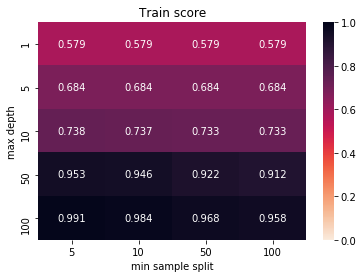

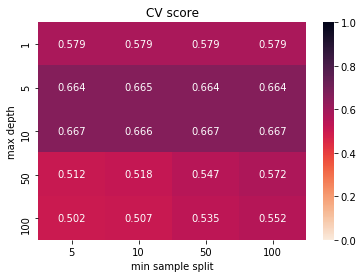

In [118]:
# Please write all the code with proper documentation
depth_s = [1, 5, 10, 50, 100]
mss_s = [5, 10, 50, 100]
auc_vs_K_plot(bow_train, y_train, depth_s, mss_s)

**We can see the train score is increasing with max depth but the cv score is reducing after a certain depth value. So this shows the easy overfitting property of the decision trees. Taking depth = 5 and min sample aplit = 5. Not taking depth = 10 as there is slight more difference between train and cv scores.**

**Analysis for max_depth = 5 and min_samples_split = 5**

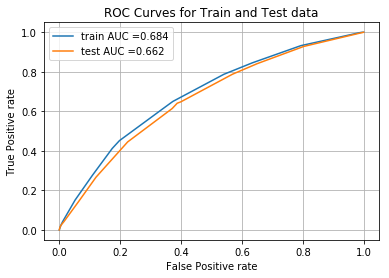


Confusion matrix for Train data with 0.8598726114649682 as threshold:


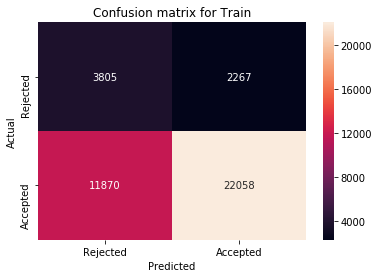


Confusion matrix for Test data with 0.8630393996247655 as threshold:


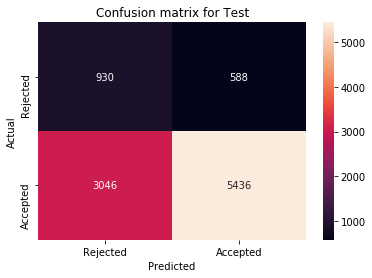

In [119]:
bow_result = {}
bow_result['5,5'] = ROC_conf_mat(bow_train, y_train, bow_test, y_test, 5, 5)

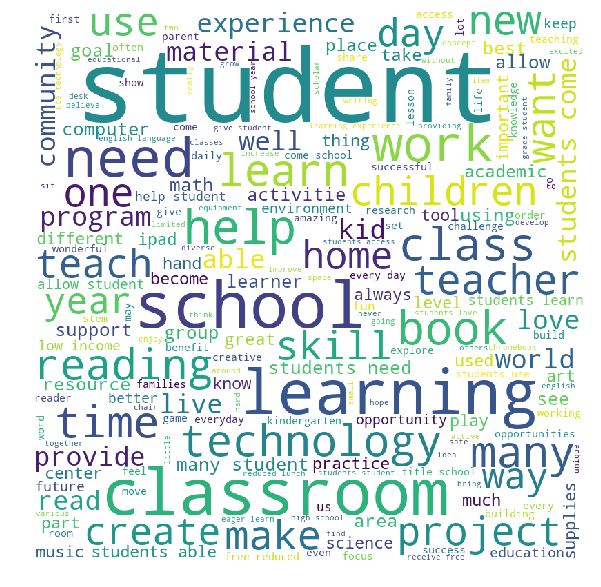

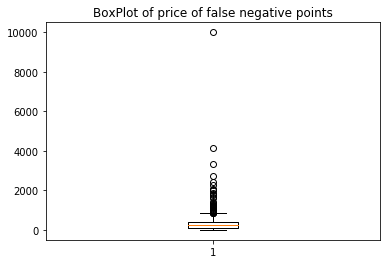

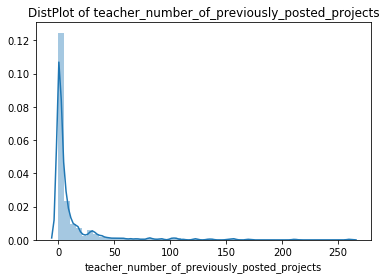

In [120]:
extra_plots(bow_result['5,5']['false_positive'])

#### 2.4.1.1 Graphviz visualization of Decision Tree on BOW,<font color='red'> SET 1</font>

In [121]:
# Please write all the code with proper documentation

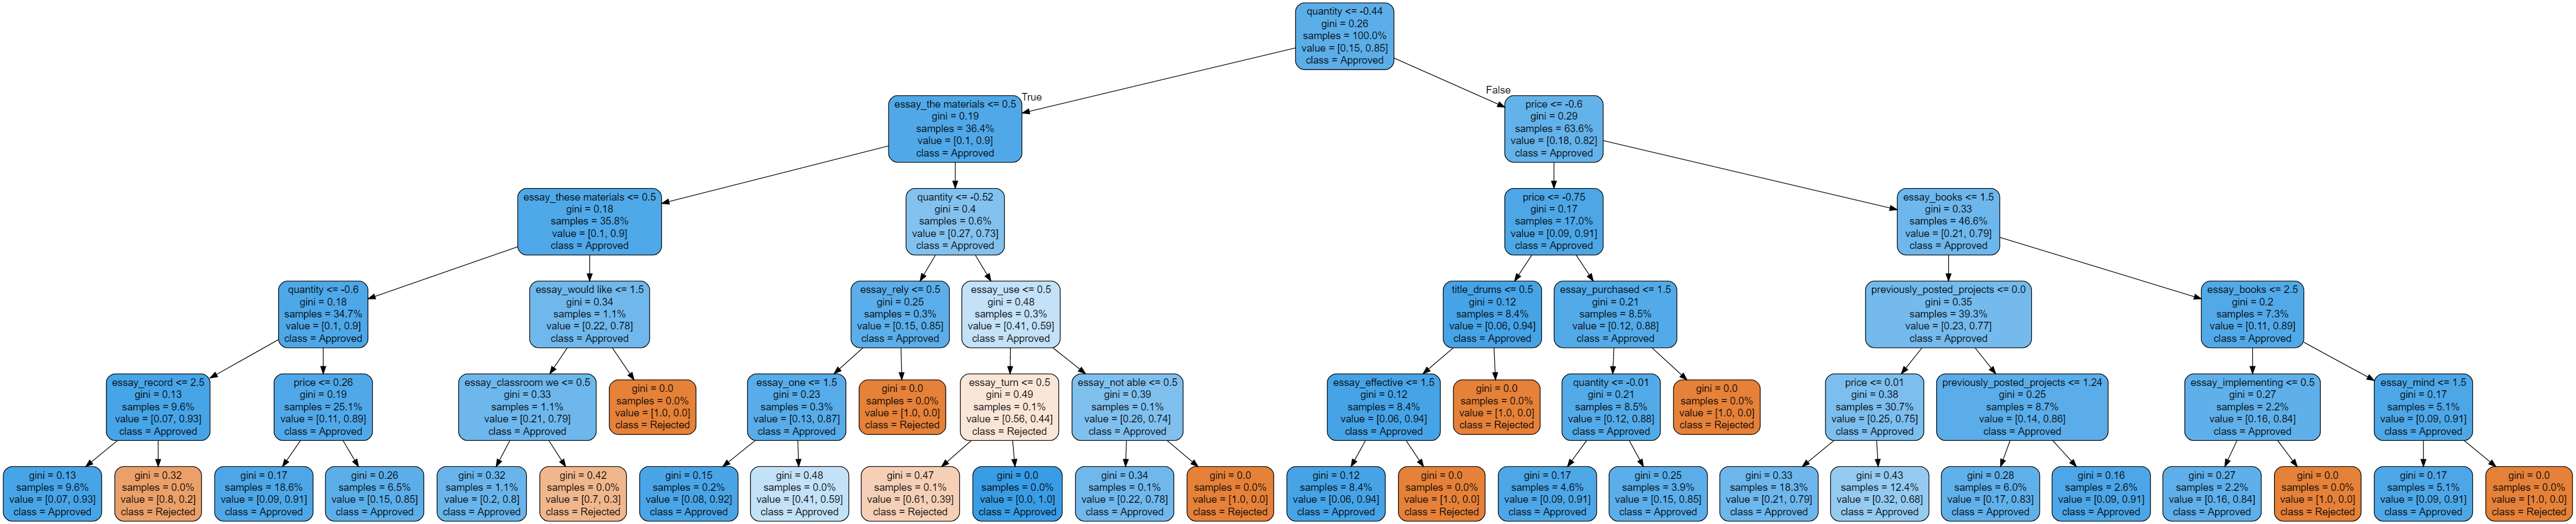

In [122]:
from sklearn.tree import export_graphviz
from IPython.display import Image, SVG, display

export_graphviz(bow_result['5,5']['model'], out_file='tree.dot', feature_names=bow_columns,\
                class_names=['Rejected', 'Approved'], rounded = True, proportion = True, precision = 2, filled = True)
Image(filename='tree_bow_5_5.png')

**The Image is not clear. So training on less depth and retrieving the image again**

**Analysis for max_depth = 3 and min_samples_split = 5**

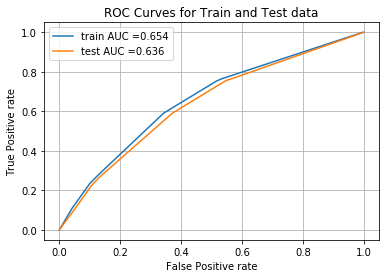


Confusion matrix for Train data with 0.8905085307271824 as threshold:


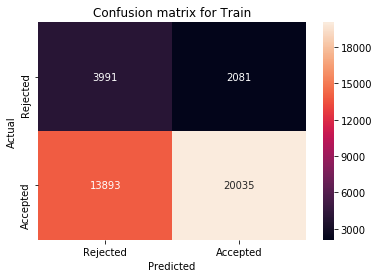


Confusion matrix for Test data with 0.8905085307271824 as threshold:


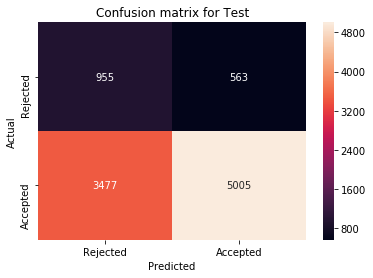

In [123]:
bow_result['3,5'] = ROC_conf_mat(bow_train, y_train, bow_test, y_test, 3, 5)

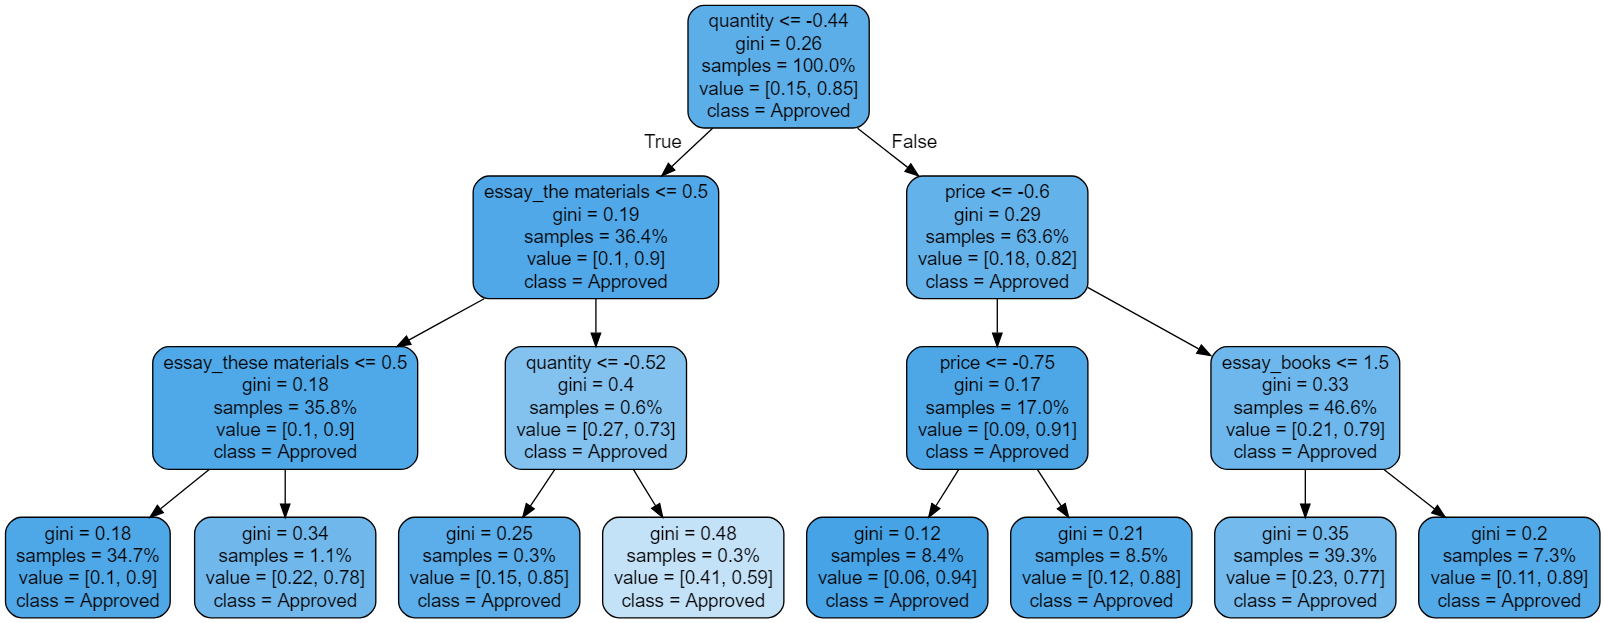

In [124]:
export_graphviz(bow_result['3,5']['model'], out_file='tree.dot', feature_names=bow_columns,\
                class_names=['Rejected', 'Approved'], rounded = True, proportion = True, precision = 2, filled = True)
Image(filename='tree_bow_3_5.png')

**With low depth we can see that our model underfitts a lot as all the leaf nodes are predicted as Approved. This is because of majority of the class. But with depth = 5 we can see rejected leaf nodes in previous image (indicated by orange nodes)**

**GraphViz images are not created by command line. I manually converted dot files to png in online. So when running the above codes (and any other codes which come after this which outputs graphviz) will show error.**

### 2.4.2 Applying Decision Trees on TFIDF,<font color='red'> SET 2</font>

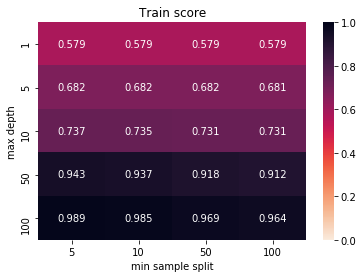

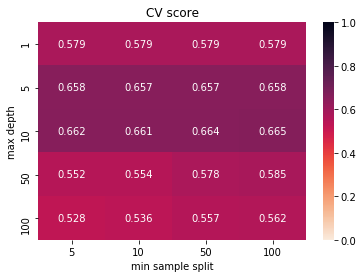

In [125]:
# Please write all the code with proper documentation
depth_s = [1, 5, 10, 50, 100]
mss_s = [5, 10, 50, 100]
auc_vs_K_plot(tfidf_train, y_train, depth_s, mss_s)

**Analysis for max_depth = 5 and min_samples_split = 50**

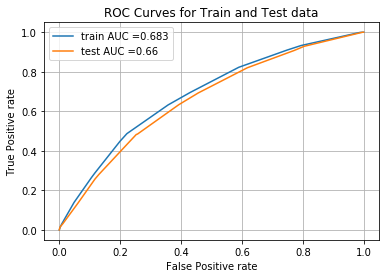


Confusion matrix for Train data with 0.8570432357043236 as threshold:


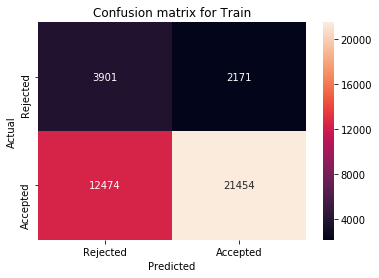


Confusion matrix for Test data with 0.8570432357043236 as threshold:


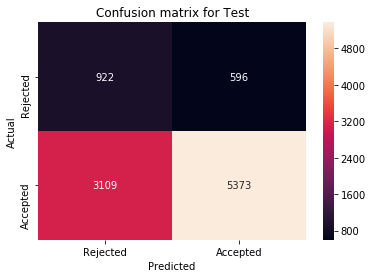

In [126]:
tfidf_result = {}
tfidf_result['5,50'] = ROC_conf_mat(tfidf_train, y_train, tfidf_test, y_test, 5, 50)

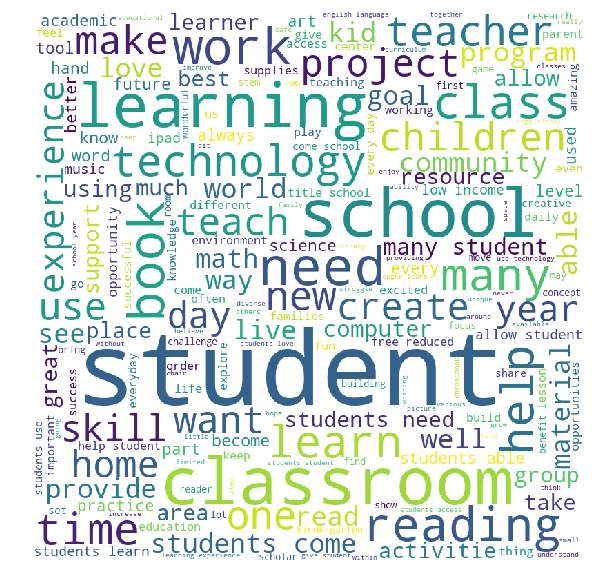

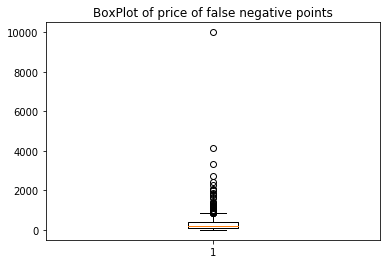

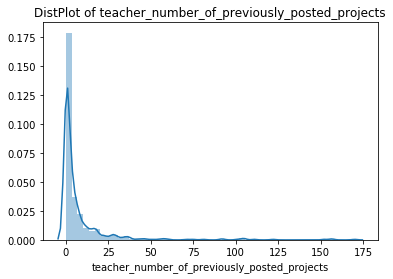

In [127]:
extra_plots(tfidf_result['5,50']['false_positive'])

#### 2.4.2.1 Graphviz visualization of Decision Tree on TFIDF,<font color='red'> SET 2</font>

**Training a less depth model to create graphviz image**

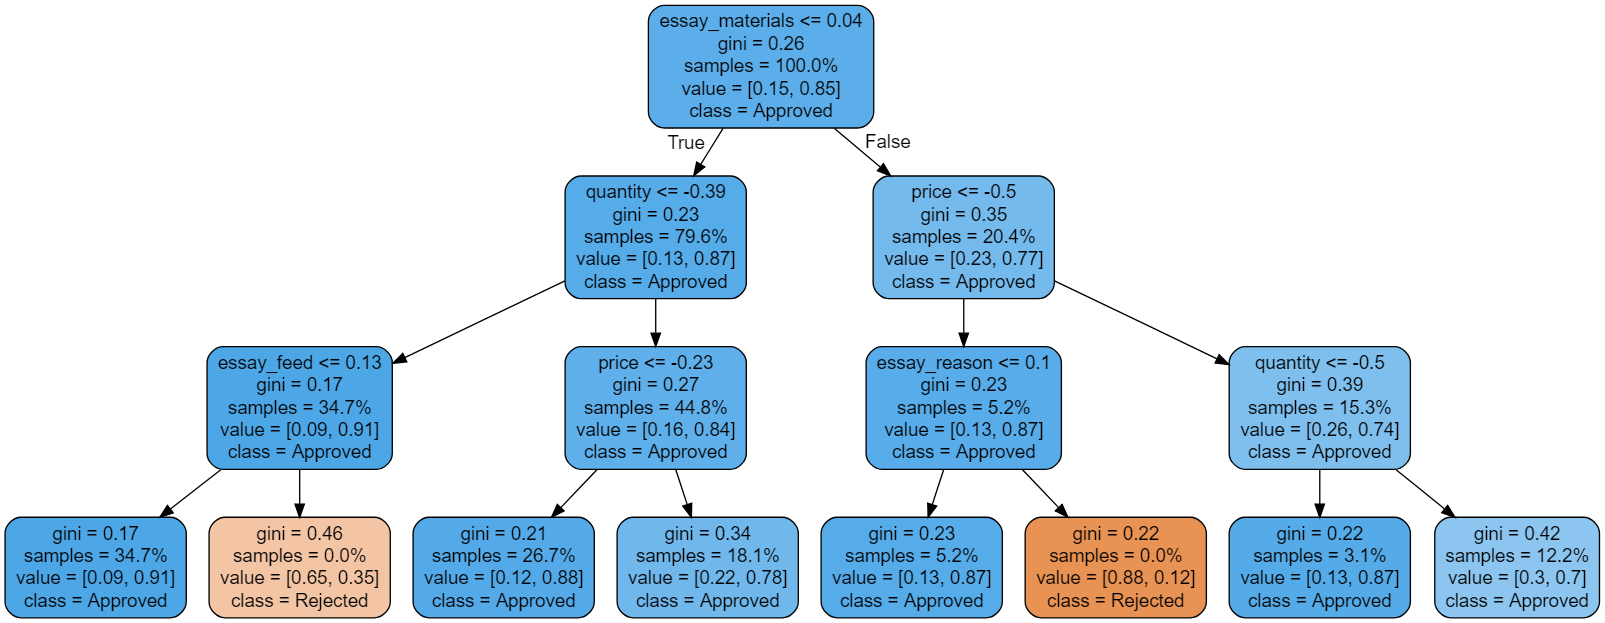

In [128]:
# Please write all the code with proper documentation
tfidf_result['3,5'] = ROC_conf_mat(tfidf_train, y_train, tfidf_test, y_test, 3, 5, plots=False)
export_graphviz(tfidf_result['3,5']['model'], out_file='tree_tfidf.dot', feature_names=tfidf_columns,\
                class_names=['Rejected', 'Approved'], rounded = True, proportion = True, precision = 2, filled = True)
Image(filename='tree_tfidf_3_5.png')

### 2.4.3 Applying Decision Trees on AVG W2V,<font color='red'> SET 3</font>

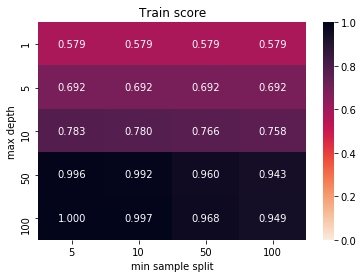

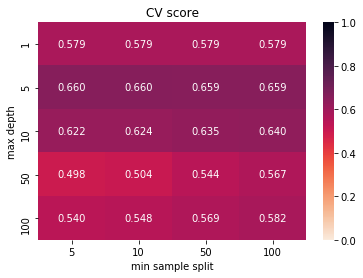

In [129]:
# Please write all the code with proper documentation
depth_s = [1, 5, 10, 50, 100]
mss_s = [5, 10, 50, 100]
auc_vs_K_plot(avgw2v_train, y_train, depth_s, mss_s)

**Analysis for max_depth = 5 and min_samples_split = 10**

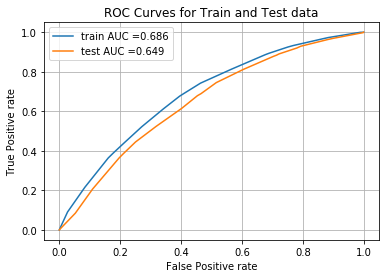


Confusion matrix for Train data with 0.8704453441295547 as threshold:


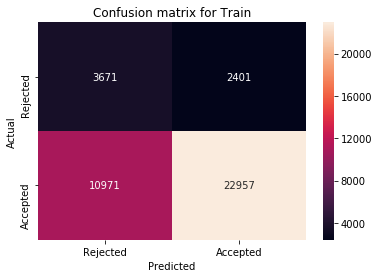


Confusion matrix for Test data with 0.8704453441295547 as threshold:


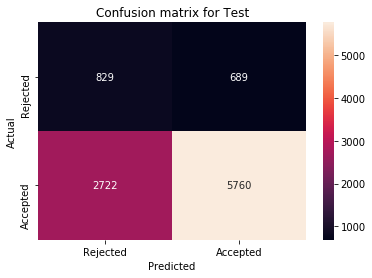

In [130]:
avgw2v_result = {}
avgw2v_result['5,10'] = ROC_conf_mat(avgw2v_train, y_train, avgw2v_test, y_test, 5, 10)

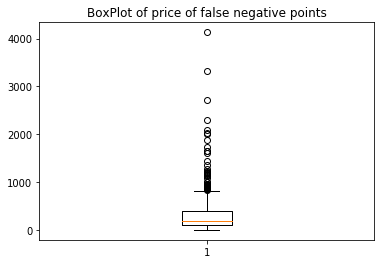

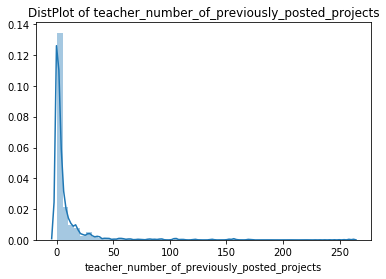

In [131]:
extra_plots(avgw2v_result['5,10']['false_positive'], wordcloud=False)

### 2.4.4 Applying Decision Trees on TFIDF W2V,<font color='red'> SET 4</font>

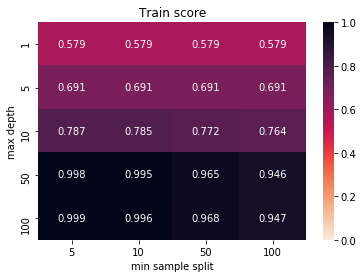

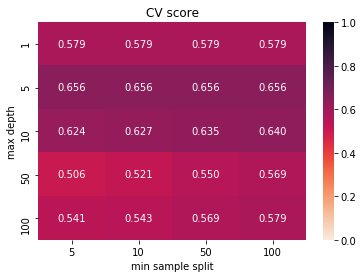

In [132]:
# Please write all the code with proper documentation
depth_s = [1, 5, 10, 50, 100]
mss_s = [5, 10, 50, 100]
auc_vs_K_plot(tfidfw2v_train, y_train, depth_s, mss_s)

**Analysis for max_depth = 5 and min_samples_split = 5**

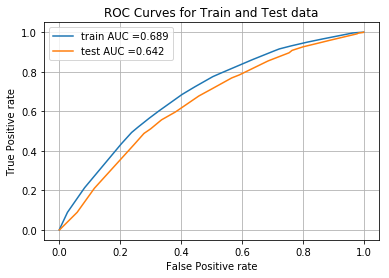


Confusion matrix for Train data with 0.8596813725490197 as threshold:


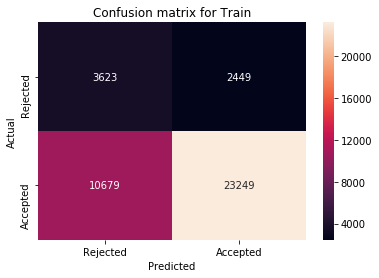


Confusion matrix for Test data with 0.8725824800910125 as threshold:


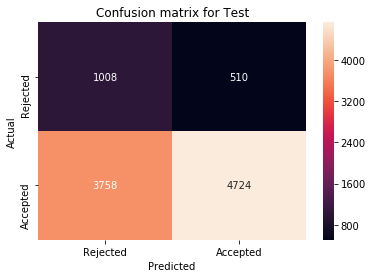

In [133]:
tfidfw2v_result = {}
tfidfw2v_result['5,5'] = ROC_conf_mat(tfidfw2v_train, y_train, tfidfw2v_test, y_test, 5, 5)

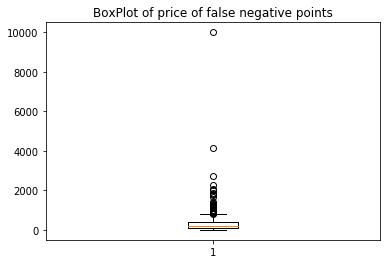

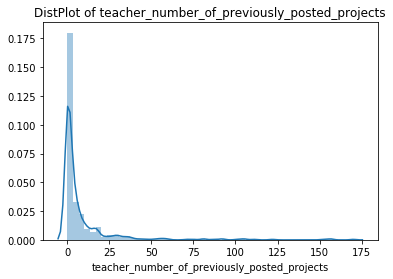

In [134]:
extra_plots(tfidfw2v_result['5,5']['false_positive'], wordcloud=False)

<h2>2.5 [Task-2]Getting top 5k features using `feature_importances_`</h2>

In [135]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

**Taking Set-2 trained model to get top features.**

In [136]:
# Getting feature importances from the trained model in set-2
feat_imp = tfidf_result['5,50']['model'].feature_importances_
# Getting indices for the top 5000 features and storing them in max_indices
max_indices = feat_imp.argsort()[-5000:][::-1]
#using max_indices we change training data and test data by having only some columns
task2_train = tfidf_train[:, max_indices]
task2_test = tfidf_test[:, max_indices]
print(task2_train.shape)
print(task2_test.shape)

(40000, 5000)
(10000, 5000)


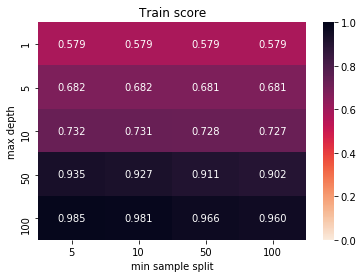

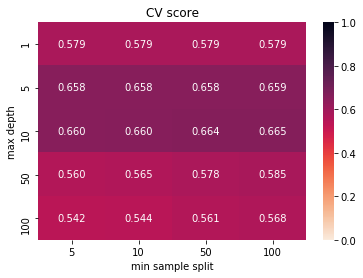

In [137]:
depth_s = [1, 5, 10, 50, 100]
mss_s = [5, 10, 50, 100]
auc_vs_K_plot(task2_train, y_train, depth_s, mss_s)

**Analysis for max_depth = 5 and min_samples_split = 5**

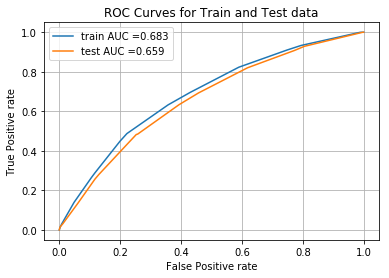


Confusion matrix for Train data with 0.8570432357043236 as threshold:


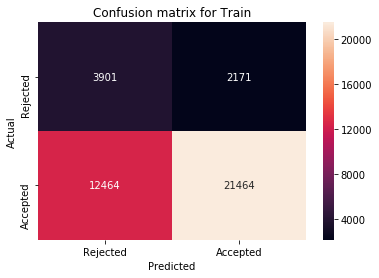


Confusion matrix for Test data with 0.8570432357043236 as threshold:


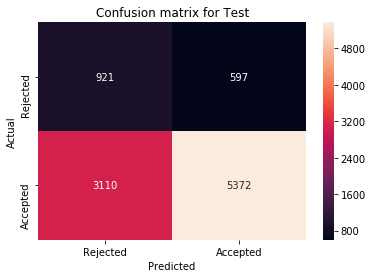

In [138]:
task2_result = {}
task2_result['5,5'] = ROC_conf_mat(task2_train, y_train, task2_test, y_test, 5, 5)

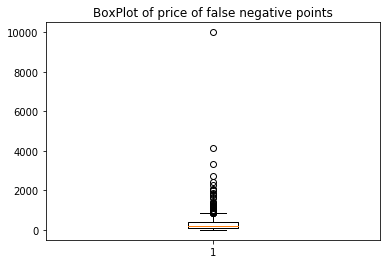

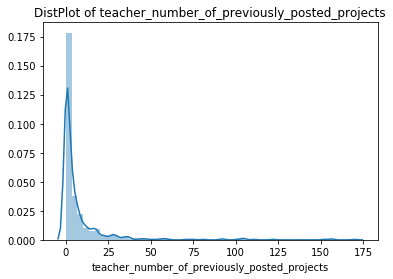

In [139]:
extra_plots(task2_result['5,5']['false_positive'], wordcloud=False)

**I used only max_depth upto 100 only as I can see even with 100 depth the models are highly overfitting and increasing depth only makes it worse. So I considered only upto 100 depth. And min_sample_split also I considered only upto 100 as it doesnt giving much performance to our models**

<h1>3. Conclusion</h1>

In [140]:
# Please compare all your models using Prettytable library

In [141]:
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ['Vectorizer', 'max_depth', 'min_samples_split', 'Train AUC', 'Test AUC']
table.add_row(['BOW', '5', '5', np.round(bow_result['5,5']['train_auc'], 3), np.round(bow_result['5,5']['test_auc'], 3)])
table.add_row(['TfIdf', '5', '50', np.round(tfidf_result['5,50']['train_auc'], 3), np.round(tfidf_result['5,50']['test_auc'], 3)])
table.add_row(['Average w2v', '5', '10', np.round(avgw2v_result['5,10']['train_auc'], 3), np.round(avgw2v_result['5,10']['test_auc'], 3)])
table.add_row(['TfIdf w2v', '5', '5', np.round(tfidfw2v_result['5,5']['train_auc'], 3), np.round(tfidfw2v_result['5,5']['test_auc'], 3)])
table.add_row(['TfIdf Task 2', '5', '5', np.round(task2_result['5,5']['train_auc'], 3), np.round(task2_result['5,5']['test_auc'], 3)])
print(table)

+--------------+-----------+-------------------+-----------+----------+
|  Vectorizer  | max_depth | min_samples_split | Train AUC | Test AUC |
+--------------+-----------+-------------------+-----------+----------+
|     BOW      |     5     |         5         |   0.684   |  0.662   |
|    TfIdf     |     5     |         50        |   0.683   |   0.66   |
| Average w2v  |     5     |         10        |   0.686   |  0.649   |
|  TfIdf w2v   |     5     |         5         |   0.689   |  0.642   |
| TfIdf Task 2 |     5     |         5         |   0.683   |  0.659   |
+--------------+-----------+-------------------+-----------+----------+


**SUMMARY:**
- **We can see all the models are doing similar. But BOW, TfIdf has slight better results. And if we see the train auc (in above codes for all models), for higher depth values we can see a lot overfitting.**
- **Decision trees didnt perform well when compared to other models i.e. Logistic Regression, SVM etc. I think because of high dimensionality in data.**
- **And after plotting word cloud of false positive points, we see words that are common in these essays (i.e. we expect them to be in high numbers as these essays are related to school projects). Words like student, school, learning, classroom are there in wordcloud from which we cant say much as they are common in these essays**
- **The pdf and boxplots of price and teacher_number_of_prev_posted_proj plots of false positive points seems to be having small values.**
- **Taking top 5K important features (Task 2) seems to be a good idea as the performance didnt reduce much. But If we see feature_importance values of features, most of them have a value of zero. So I guess we can reduce the dimention even furthur without reducing models performance**

**Note: The images of graphviz are created by converting the dot files externally (using online tools) and not by the code. So They are found in pdf but if we re-run the notebook the images may not be produced and results in error at that code blocks**